In [32]:
import numpy as np
from qeh import Heterostructure
from default_parameters import get_thickness, get_intermass
import ase.units

Hartree = ase.units.Hartree
Bohr = ase.units.Bohr

# %% HElPER FUNCTIONS FROM GPAW
import pickle
def load(fd):
    try:
        return pickle.load(fd, encoding='latin1')
    except TypeError:
        return pickle.load(fd)

def get_exciton_screened_potential_r_an(r_array, e_distr=None,
                                         h_distr=None, Wq_name=None,
                                         tweak=None):
        dBar=10/Bohr
        eps2=2
        W_r=-(1/eps2)*1/np.sqrt(r_array**2+dBar**2)
        

        return r_array, W_r

# %% CRUCIAL FUNCTION WHICH WE SHOULD IMPLEMENT
def get_exciton_binding_energies_coulomb(hs, eff_mass, L_min=-50, L_max=10,
                                     Delta=0.1, e_distr=None, h_distr=None,
                                     Wq_name=None, tweak=None):
                                     
        from scipy.linalg import eig
        r_space = np.arange(L_min, L_max, Delta)
        Nint = len(r_space)
        
        # EDIT THIS
        r, W_r = get_exciton_screened_potential_r_an(r_array=np.exp(r_space),
                                                       e_distr=e_distr,
                                                       h_distr=h_distr,
                                                       Wq_name=None,
                                                       tweak=tweak)
        #print(W_r[0:10])
        #print(r[-10:])
        H = np.zeros((Nint, Nint), dtype=complex)
        for i in range(0, Nint):
            r_abs = np.exp(r_space[i])
            H[i, i] = - 1. / r_abs**2 / 2. / eff_mass \
                * (-2. / Delta**2 + 1. / 4.) + W_r[i]
            if i + 1 < Nint:
                H[i, i + 1] = -1. / r_abs**2 / 2. / eff_mass \
                    * (1. / Delta**2 - 1. / 2. / Delta)
            if i - 1 >= 0:
                H[i, i - 1] = -1. / r_abs**2 / 2. / eff_mass \
                    * (1. / Delta**2 + 1. / 2. / Delta)

        ee, ev = eig(H)
        index_sort = np.argsort(ee.real)
        ee = ee[index_sort]
        ev = ev[:, index_sort]
        return ee * Hartree, ev

# %% OUR OWN FUNCTIONS
def get_E_b_for_hs(hs, e_layer, h_layer, nFilling, nPadding):
    '''
    @returns: E_b
    '''
    Hartree = ase.units.Hartree
    Bohr = ase.units.Bohr

    # Exciton Screened Potential
    e_distr = np.array([0, 0]*nPadding + [0, 0] + [0, 0]*nFilling + [1, 0] + [0,0]*nPadding)
    h_distr = np.array([0, 0]*nPadding + [1, 0] + [0, 0]*nFilling + [0, 0] + [0,0]*nPadding)

    # Exciton Binding Energies
    ee, ev = get_exciton_binding_energies_coulomb(hs,eff_mass=get_intermass('H-' + e_layer, 'H-' + h_layer),
                                            e_distr=e_distr,
                                            h_distr=h_distr)
    
    # TODO: This is where we sohuld use our own function also
    # ee_2d_coulomb, ev_2d_coullomb = get_exciton_binding_energies_coulomb(...)
    
    E_b = -ee[0].real
    print(E_b)
    # Return in units of eV and Å.
    # Note: The units of V_ee and V_eh (in q-space) are unknown (we don't know the FT)
    return E_b

def calculate_and_save_binding_energies(materials, nPadding, nFilling):
    N = len(materials)
    E_b_heat_mat = np.zeros((N,N))
    E_b_heat_ylabels = ['n-' + m for m in materials]
    E_b_heat_xlabels = ['p-' + m for m in materials]
    E_b = [[]]*N**2
    bilayer = [[]]*N**2

    count = 0
    for (i_e, e_layer) in enumerate(materials):
        for (i_h, h_layer) in enumerate(materials):
            bilayer[count] = 'n-' + e_layer + ', ' + 'p-' + h_layer
            print(bilayer[count])

            layers = ['BN'] * nPadding + [e_layer] + ['BN'] * nFilling + [h_layer] + ['BN'] * nPadding
            d = [(get_thickness(l) + get_thickness(layers[i+1]))/2 for (i,l) in enumerate(layers[:-1])]

            hs = Heterostructure(structure=layers, d=d, include_dipole=True, wmax=0, qmax=1, d0=0)              

            E_b[count] = get_E_b_for_hs(hs, e_layer, h_layer, nFilling, nPadding)
            E_b_heat_mat[i_e, i_h] = E_b[count]

            count += 1
    
    np.savez('wannier_analytic_nFilling=' + str(nFilling) + '_nPadding=' + str(nPadding) + '.npz',
        bilayer=bilayer, E_b=E_b, E_b_heat_mat=E_b_heat_mat,
        E_b_heat_xlabels=E_b_heat_xlabels, E_b_heat_ylabels=E_b_heat_ylabels)

#if __name__ == '__main__':
#    import os
#    abspath = os.path.abspath(__file__)
#    dname = os.path.dirname(abspath)
#    os.chdir(dname)

calculate_and_save_binding_energies(materials=['WS2','MoS2','WSe2','MoSe2'], nPadding=0, nFilling=3)


n-WS2, p-WS2
[-0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886
 -0.02645886 -0.02645886 -0.02645886 -0.02645886]
[ 8103.08392758  8955.29270349  9897.12905875 10938.01920817
 12088.38073023 13359.72682967 14764.78156559 16317.60719803
 18033.74492784 19930.37043825]
0.3566875074311844
n-WS2, p-MoS2
[-0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886
 -0.02645886 -0.02645886 -0.02645886 -0.02645886]
[ 8103.08392758  8955.29270349  9897.12905875 10938.01920817
 12088.38073023 13359.72682967 14764.78156559 16317.60719803
 18033.74492784 19930.37043825]
0.3784179703004349
n-WS2, p-WSe2
[-0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.02645886
 -0.02645886 -0.02645886 -0.02645886 -0.02645886]
[ 8103.08392758  8955.29270349  9897.12905875 10938.01920817
 12088.38073023 13359.72682967 14764.78156559 16317.60719803
 18033.74492784 19930.37043825]
0.35962977767518495
n-WS2, p-MoSe2
[-0.02645886 -0.02645886 -0.02645886 -0.02645886 -0.026

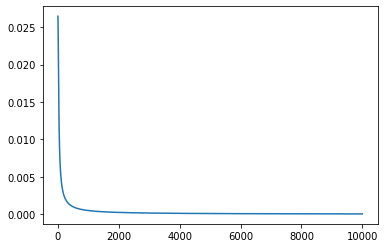

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
r_array=np.arange(0,10**4,0.1)
eps2=2
dBar=10/Bohr
W_r=(1/eps2)*1/np.sqrt(r_array**2+dBar**2)
plt.plot(r_array,W_r)
plt.show()